## **Columns/Features**

**Country** Country

**Year** Year

**Status** Developed or Developing status

**Life expectancy** Life Expectancy in age

**Adult Mortality** Adult Mortality Rates of both sexes (probability of dying between 15 and 60 years per 1000 population)

**infant** deaths Number of Infant Deaths per 1000 population

**Alcohol** Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol)
percentage 

**expenditure** Expenditure on health as a percentage of Gross Domestic Product per capita(%)

**Hepatitis B** Hepatitis B (HepB) immunization coverage among 1-year-olds (%)

**Measles** Measles - number of reported cases per 1000 population

**BMI** Average Body Mass Index of entire population

**under-five deaths** Number of under-five deaths per 1000 population

**Polio** Polio (Pol3) immunization coverage among 1-year-olds (%)

**Total expenditure** General government expenditure on health as a percentage of total government expenditure (%)

**Diphtheria** Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%)

**HIV/AIDS** Deaths per 1 000 live births HIV/AIDS (0-4 years)

**GDP** Gross Domestic Product per capita (in USD)

**Population** Population of the country

**thinness 1-19 years** Prevalence of thinness among children and adolescents for Age 10 to 19 (% )

**thinness 5-9 years** Prevalence of thinness among children for Age 5 to 9(%)

**Income composition of resources** Human Development Index in terms of income composition of resources (index ranging from 0 to 1)

**Schooling** Number of years of Schooling(years) 

In [1]:

%%capture
!pip install eli5
!pip install pdpbox
!pip install shap
!pip install category_encoders==2.*
!pip install pandas-profiling==2.*
!pip3 install xgboost

In [2]:
# Importing Libraries needed for the project. 
import pandas_profiling
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, r2_score
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import xgboost
from xgboost import XGBRegressor
import eli5
from eli5.sklearn import PermutationImportance
%matplotlib inline
plt.rcParams['figure.dpi'] = 144
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import seaborn as sns
import plotly.graph_objects as go
import shap;

## **Data Leakage Features and Why**

**Income composition of resources** - The Human Development Index (HDI) is a statistic composite index of life expectancy, education, and per capita income indicators, which are used to rank countries into four tiers of human development. A country scores a higher HDI when the lifespan is higher, the education level is higher, and the gross national income GNI (PPP) per capita is higher. https://en.wikipedia.org/wiki/Human_Development_Index


**expenditure** is using GDP and total expenditure

**infant mortality** could also be representated by under_five_deaths

**under_five_deaths and adult mortality** Adult mortality is “The number of people that die between ages 15 and 60 yrs old per 1000 people” If this feature is in the predictive model, then the insight would be “In countries where more people die young, people don’t live as long on average.”

In [3]:
# Loading the data
data = 'https://raw.githubusercontent.com/EvidenceN/Life-Expectancy-Prediction/master/Life%20Expectancy/Data/Life%20Expectancy%20Data.csv'

life = pd.read_csv(data)

print(life.shape)
life.head()

(2938, 22)


Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0            263.0   
1  Afghanistan  2014  Developing              59.9            271.0   
2  Afghanistan  2013  Developing              59.9            268.0   
3  Afghanistan  2012  Developing              59.5            272.0   
4  Afghanistan  2011  Developing              59.2            275.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   ...  \
0             62     0.01               71.279624         65.0      1154  ...   
1             64     0.01               73.523582         62.0       492  ...   
2             66     0.01               73.219243         64.0       430  ...   
3             69     0.01               78.184215         67.0      2787  ...   
4             71     0.01                7.097109         68.0      3013  ...   

   Polio  Total expenditure  Diphtheria    HIV/AIDS         GDP  Population  \
0    6.0               8.16         65.0        0.1  584.259210  33736494.0   
1   58.0               8.18         62.0        0.1  612.696514    327582.0   
2   62.0               8.13         64.0        0.1  631.744976  31731688.0   
3   67.0               8.52         67.0        0.1  669.959000   3696958.0   
4   68.0               7.87         68.0        0.1   63.537231   2978599.0   

    thinness  1-19 years   thinness 5-9 years  \
0                   17.2                 17.3   
1                   17.5                 17.5   
2                   17.7                 17.7   
3                   17.9                 18.0   
4                   18.2                 18.2   

   Income composition of resources  Schooling  
0                            0.479       10.1  
1                            0.476       10.0  
2                            0.470        9.9  
3                            0.463        9.8  
4                            0.454        9.5  

[5 rows x 22 columns]

In [4]:
# Get a profile report of the dataset. 
profile = pandas_profiling.ProfileReport(life)
profile

**Dealing with missing data.** A lot of GDP and Population data is missing for some countries. 

Due to the nature of the dataset, i can not use imputation with a mean or median strategy. If i use imputation, then i am taking information from other countries and putting it in for a different country. 

for example, i will be taking population and GDP information from a different countries and imputing it as the population and GDP of a different countries. That information would be inaccurate. 

I could meticoulously look up the information from the countries with missing data, but that would consume a lot of time. 

Drop rows with missing gdp and population information. That would leave me with 145 countries instead of 193 and 
75% of the total data. By doing this, i will loose 25% of the data. 

for other features like Bmi, thinness, hepatitis B with missing values, i will input 0's for those missing values. 
if values are missing for those features, 0 is a safe assumption and won't skew the data or disrupt the interpretation
of the data

XGboost can handle nan, but other models might struggle to handle nan, since imputation is not a viable option, then
i will use 0 in place of nan's

drop country and years because we are not trying to see if the life exptancy of a country changes from year to year. The country and year the data originated from should 
not be a predictor of life expectancy. 

The objective is to use health and economic factors to predict life expectancy. Having data from different countries over the
years allows for diversity of information. 

In [5]:
# drop gdp and population and life expectancy missing values
life = life.dropna(subset=['GDP', 'Population', 'Life_expectancy_'])

In [6]:
# get the mean baseline because this is a regression problem
# with regression, the baseline can be as simple as the mean.

mean_baseline = life['Life_expectancy_'].mean()
errors = mean_baseline - life['Life_expectancy_']
mean_absolute_error_ = errors.abs().mean()
print(f'Mean Baseline: {mean_baseline:.1f} years')
print('Without any other factors, life expectancy could be guessed to be')
print(f'{mean_baseline:.1f}yrs and will be off by a mean absolute error of {round(mean_absolute_error_, 2)}')

Mean Baseline: 68.7 years
Without any other factors, life expectancy could be guessed to be
68.7yrs and will be off by a mean absolute error of 8.07


In [7]:
# split into train, test, validation 15% for testing, 15% for validation, 70% training. 
# No stratification in splitting because of ValueError: The least populated class in y has 
# only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

from sklearn.model_selection import train_test_split

train, test = train_test_split(life, test_size=0.15, random_state=42)

train, val = train_test_split(train, test_size=0.20, random_state=42)

In [8]:
# function to perform data cleaning on all datasets. 

def wrangle(x):
    x = x.copy()
    
    x.columns = [col.lower()         # make column names lowercase
                .strip('_')         # strip leading/trailing underscores
                .replace('_', ' ')  # replace remaining punctuation with spaces
                .replace('-', ' ') 
                .replace('/', ' ')
                for col in x.columns]

    # dropping columns with leakage
    x = x.drop(columns = ['country', 'year', 'income composition of resources',
                         'percentage expenditure', 'infant deaths', 
                          'under five deaths', 'adult mortality'])
    
    # filling nan values with 0 because I can't do imputation and the missing
    # values can be assumed to be 0.
    
    x = x.fillna(value=0)
    
    return x

In [9]:
# clean all data the same way
train = wrangle(train)
test = wrangle(test)
val = wrangle(val)

In [10]:
# defining x and y values for training, validation, and test sets. 

target = 'life expectancy'
features = train.columns.drop(target)

x_train = train[features]
y_train = train[target]
x_val = val[features]
y_val = val[target]
x_test = test[features]
y_test = test[target]

In [11]:
# Function to build multiple Models at once. 

def model(x_train, y_train, x_val, y_val):

  # Defining Global Coefficients so that it can be used
  # outside of the function. 
  global coefficients_lr, coefficients_ridge, importances_tree
  global importances_boost, importances_forest, forest

  ##lr = linear regression model
  
  lr = make_pipeline(
      ce.OneHotEncoder(),
      LinearRegression())
  
  # Getting error and R^2 scores from linear regression model. 
  # fitting the model from linear regression pipeline
  lr.fit(x_train, y_train)
  # R2 score from linear regression model
  lr_score = lr.score(x_val, y_val)
  print(f'LinearRegression R^2 Score {lr_score}')
  # mean absolute error from linear regression model
  y_pred_lr = lr.predict(x_val)
  mae_lr = mean_absolute_error(y_val, y_pred_lr)
  print(f'LinearRegression mean_absolute_error {mae_lr}\n' )
  # coefficients from linear regression model
  coeff_lr = lr.named_steps['linearregression'].coef_
  print(f'LinearRegression Coefficient {coeff_lr}')
  #Intercept from linear regression model. 
  intercept_lr = lr.named_steps['linearregression'].intercept_
  print(f'LinearRegression Intercept {intercept_lr}\n')

  # plotting the coefficients from linear regression model.
  encoder = lr.named_steps['onehotencoder']
  columns_lr = encoder.transform(x_val).columns
  coefficients_lr = pd.Series(coeff_lr, columns_lr)

  ## Ridge Regression Model

  ridge = make_pipeline(
        ce.OneHotEncoder(),
        StandardScaler(),
        Ridge(alpha=10))

  # fitting the model
  ridge.fit(x_train, y_train)

  # mean absolute error for ridge regresssion model
  y_pred_ridge = ridge.predict(x_val)
  mae_ridge = mean_absolute_error(y_val, y_pred_ridge)
  print(f'Ridge regression mean_absolute_error {mae_ridge}' )

  # R2 score for ridge regresssion model
  ridge_score = ridge.score(x_val, y_val,)
  print(f'Ridge Regression Score R^2 Score {ridge_score}\n')

  coeff_ridge = ridge.named_steps['ridge'].coef_
  print(f'Ridge Regression Coefficient {coeff_ridge}')

  intercept_ridge = ridge.named_steps['ridge'].intercept_
  print(f'Ridge Regression Intercept {intercept_ridge}\n')

  # plotting the coefficients for ridge regresssion model
  encoder = ridge.named_steps['onehotencoder']
  columns_ridge = encoder.transform(x_val).columns
  coefficients_ridge = pd.Series(coeff_ridge, columns_ridge)

  ## Decision Tree Model

  tree = make_pipeline(
    ce.OrdinalEncoder(),
    DecisionTreeRegressor(random_state=42))

  tree.fit(x_train, y_train)

  # mean absolute error for decision tree model
  y_pred = tree.predict(x_val)
  mae = mean_absolute_error(y_val, y_pred)
  print(f'Decision tree mean_absolute_error {mae}' )

  # R2 score for decision tree model
  tree_score = tree.score(x_val, y_val,)
  print(f'Decision tree Score R^2 Score {tree_score}\n')

  # plotting the feature importances for decision tree model
  tree_model = tree.named_steps['decisiontreeregressor']
  encoder = tree.named_steps['ordinalencoder']
  columns = encoder.transform(x_val).columns
  importances_tree = pd.Series(tree_model.feature_importances_, columns)

  ## random forest model

  forest = make_pipeline(
      ce.OrdinalEncoder(),
      RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1)
  )

  forest.fit(x_train, y_train)

  # mean absolute error for random forest model
  y_pred_val = forest.predict(x_val)
  mae = mean_absolute_error(y_val, y_pred_val)
  print(f'random forest mean_absolute_error {mae}' )

  # R2 score for random forest model
  forest_score = forest.score(x_val, y_val,)

  print(f'random forest Score R^2 Score {forest_score}\n')

  # plotting the feature importances for random forest model
  model_forest = forest.named_steps['randomforestregressor']
  encoder = forest.named_steps['ordinalencoder']
  columns = encoder.transform(x_val).columns
  importances_forest = pd.Series(model_forest.feature_importances_, columns)

  ## gradient boosting model

  boost = make_pipeline(
      ce.OrdinalEncoder(),
      XGBRegressor(random_state=42, n_estimators=100, n_jobs=-1)
  );

  boost.fit(x_train, y_train)

  # mean absolute error for gradient boosting model
  y_pred_boost = boost.predict(x_val)
  mae_boost = mean_absolute_error(y_val, y_pred_boost)
  print(f'gradient boosting mean_absolute_error {mae_boost}' )

  # R2 score for gradient boosting model
  boost_score = boost.score(x_val, y_val,)
  print(f'gradient boosting R^2 Score {boost_score}')

  # defining the dataframe for plotting the feature importances for gradient boosting model
  model_boost = boost.named_steps['xgbregressor']
  encoder = boost.named_steps['ordinalencoder']
  columns = encoder.transform(x_val).columns
  importances_boost = pd.Series(model_boost.feature_importances_, columns);

In [12]:
model(x_train, y_train, x_val, y_val)

LinearRegression R^2 Score 0.7924298077605403
LinearRegression mean_absolute_error 3.3559367471030166

LinearRegression Coefficient [ 9.52442702e-01 -9.52442700e-01 -1.90949181e-01  1.51500298e-03
 -1.31694130e-05  5.95247851e-02  1.44886566e-02  8.09240442e-02
  2.67738759e-02 -7.21092247e-01  7.15755691e-05  2.07511288e-09
 -1.25679480e-01  2.08235803e-02  1.39454400e+00]
LinearRegression Intercept 48.8757565361458

Ridge regression mean_absolute_error 3.3542269812819976
Ridge Regression Score R^2 Score 0.7928517626202713

Ridge Regression Coefficient [ 0.36902278 -0.36902278 -0.75512343  0.06741744 -0.16383104  1.20926949
  0.36630437  0.21263604  0.67118016 -3.63210266  1.01812502  0.1407543
 -0.57726672  0.06677514  4.70555803]
Ridge Regression Intercept 68.67859466493168

Decision tree mean_absolute_error 2.1425974025974024
Decision tree Score R^2 Score 0.8689457498611988

random forest mean_absolute_error 1.5128519480519453
random forest Score R^2 Score 0.9515193731036575

[17:3

Text(0.5, 1.0, 'Visualization for Linear Regression Model Coefficients')

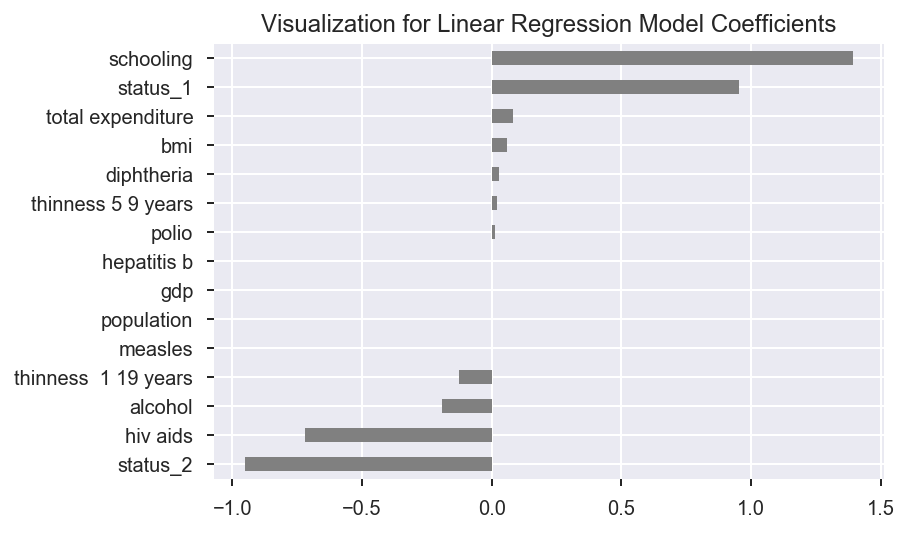

In [13]:
# Visualization for Linear Regression model.
coefficients_lr.sort_values().plot.barh(color='grey')
plt.title('Visualization for Linear Regression Model Coefficients')

Text(0.5, 1.0, 'Visualization for Ridge Regression Model Coefficients')

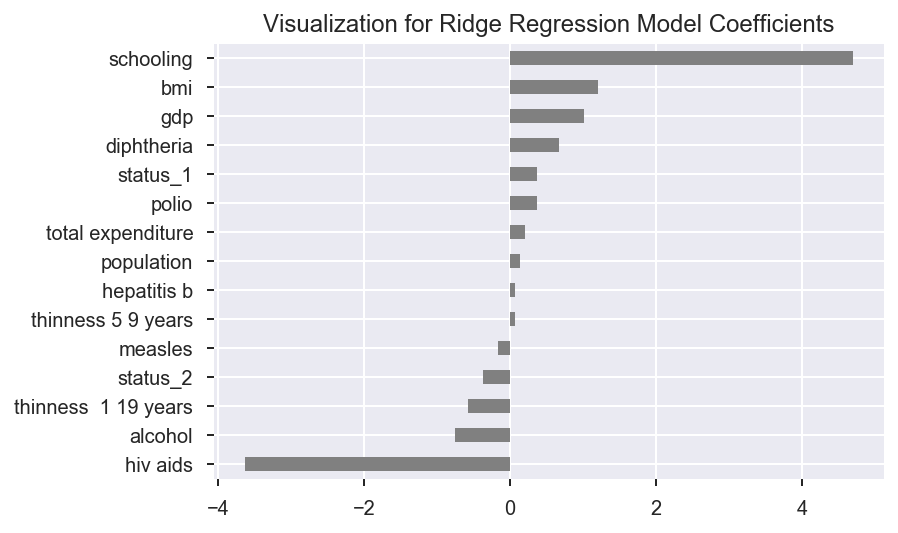

In [14]:
# Visualization for Ridge Regression model.
coefficients_ridge.sort_values().plot.barh(color='grey')
plt.title('Visualization for Ridge Regression Model Coefficients')

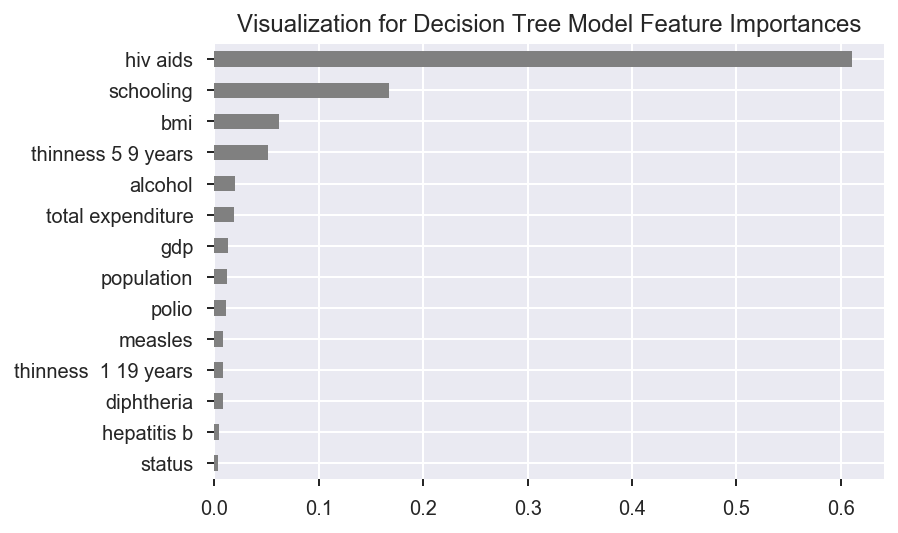

In [15]:
# Visualization for Decision model.
importances_tree.sort_values().plot.barh(color='grey')
plt.title('Visualization for Decision Tree Model Feature Importances');

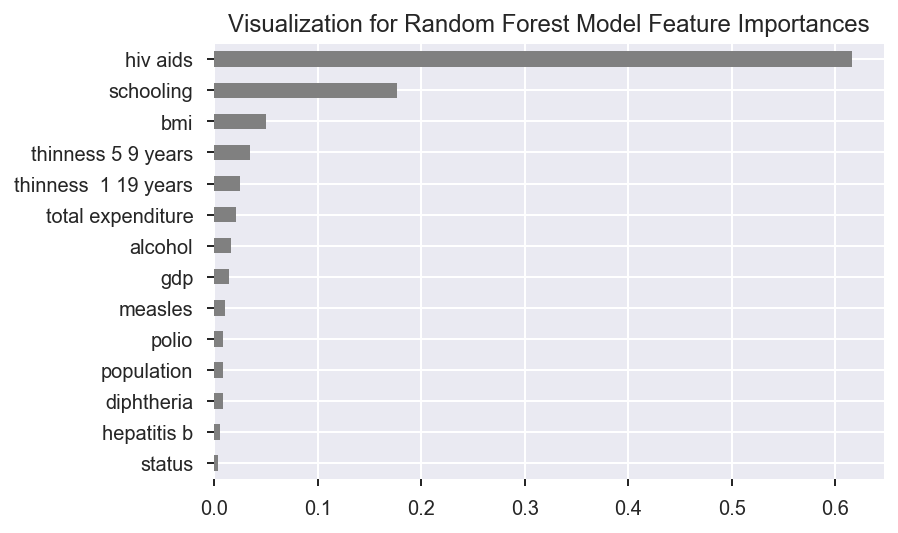

In [16]:
# Visualization for Random Forest model.
importances_forest.sort_values().plot.barh(color='grey')
plt.title('Visualization for Random Forest Model Feature Importances');

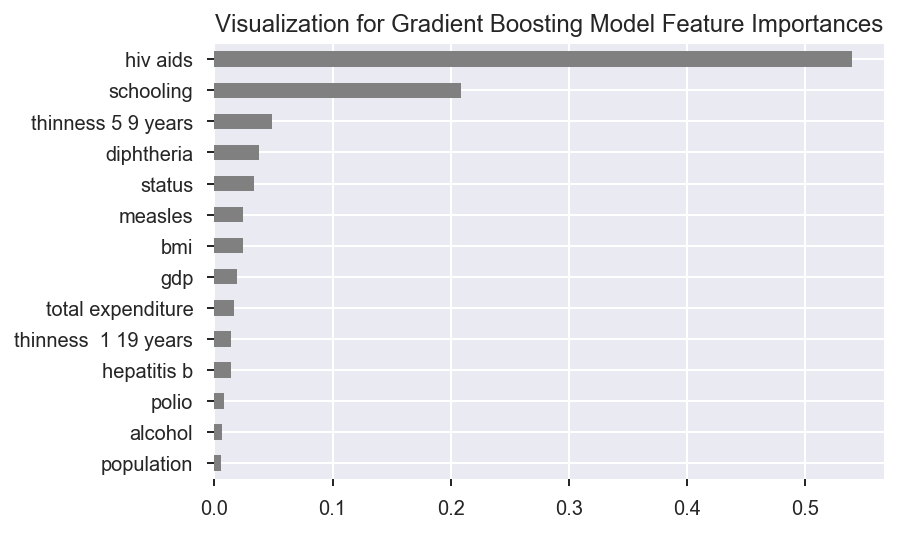

In [17]:
# Visualization for gradient boost model.
importances_boost.sort_values().plot.barh(color='grey')
plt.title('Visualization for Gradient Boosting Model Feature Importances');

In [18]:
# using the best model which is the random forest model for prediction
# with the test data set. 
y_pred_test = forest.predict(x_test)
mae = mean_absolute_error(y_test, y_pred_test)
print(f'random forest test mean_absolute_error {mae}' )

# R2 score for test data set
forest_score = forest.score(x_test, y_test,)
print(f'random forest test Score R^2 Score {forest_score}')

random forest test mean_absolute_error 1.6843852941176432
random forest test Score R^2 Score 0.9437965535784689


In [19]:
# Permutation Importance Function. Eli5 - the library used for permutation
# importance calculations doesn't work with pipeline models. So, everything has
# to be preprocess before putting it in a model. 

def permutation(x_train, y_train, x_val, y_val):

  # Pre processing the data using a pipeline
  pre_processing = make_pipeline(
      ce.OrdinalEncoder())

  x_train_encoded =  pre_processing.fit_transform(x_train)
  x_val_encoded =  pre_processing.transform(x_val)

  # fitting the model
  model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
  model.fit(x_train_encoded, y_train)

  # instantiating and setting the permutation parameters
  permuter = PermutationImportance(
      model,
      scoring = 'r2', 
      n_iter = 5,
      random_state = 42
  )

  # fitting the permutation importance to the validation dataset
  permuter.fit(x_val_encoded, y_val)

  # getting and plotting the graph from the permution calculations
  feature_names = x_val.columns.to_list()
  pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

  metric = eli5.show_weights(
      permuter,
      top=None,
      feature_names=feature_names,
  )

  return metric

In [20]:
permutation(x_train, y_train, x_val, y_val)

In [21]:
# Function for single feature partial dependence plot(PDP)

def pdp(feature, title="", ylabel="", xlabel="", xlim=(0,10)):

  # defining the parameters for the pdp plot
  isolated = pdp_isolate(
    model=forest,
    dataset=x_val,
    model_features = x_val.columns,
    feature = feature,
    num_grid_points=50
    )

  # plotting the isolated features
  pdp_plot(isolated, feature_name=feature)
  plt.xlim(xlim)
  plt.title(title)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)

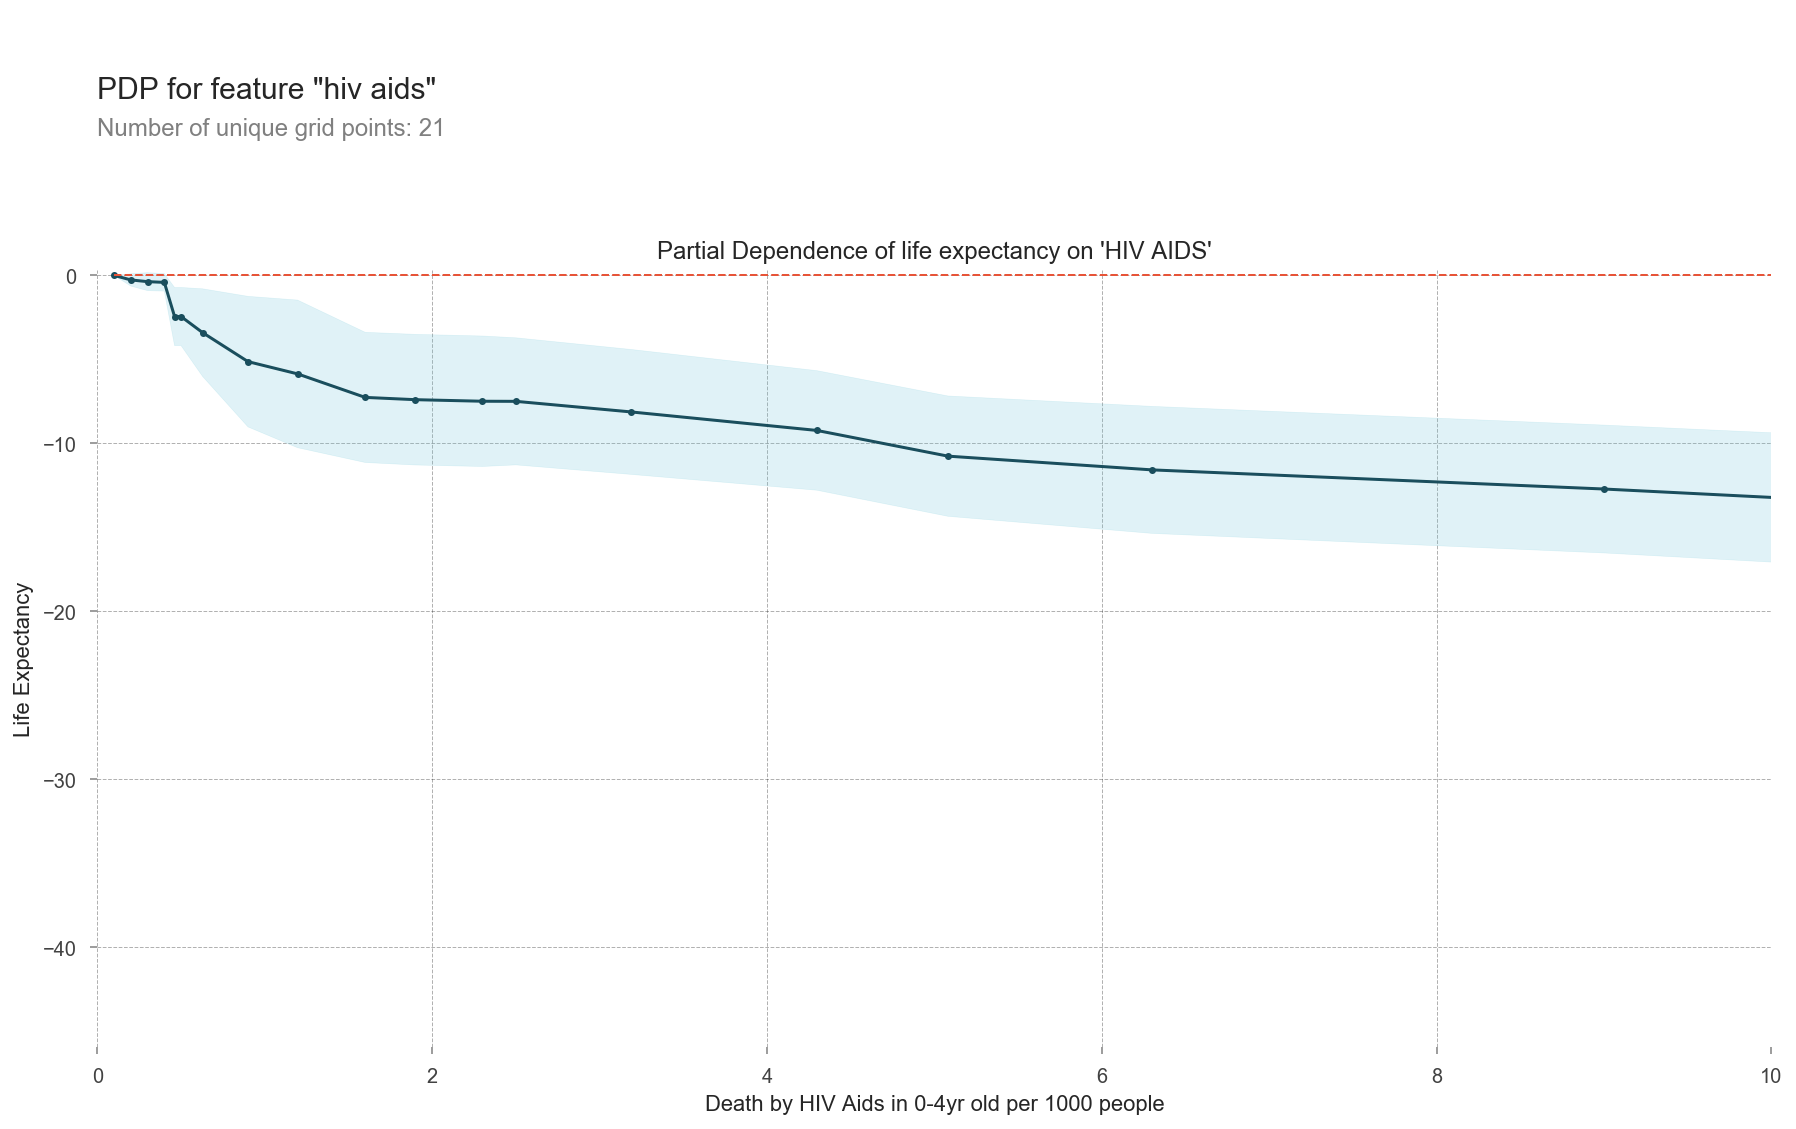

In [22]:
# pdp plot for HIV AIDS feature
pdp('hiv aids', 
    title = "Partial Dependence of life expectancy on 'HIV AIDS'",
    ylabel='Life Expectancy',
    xlabel='Death by HIV Aids in 0-4yr old per 1000 people')

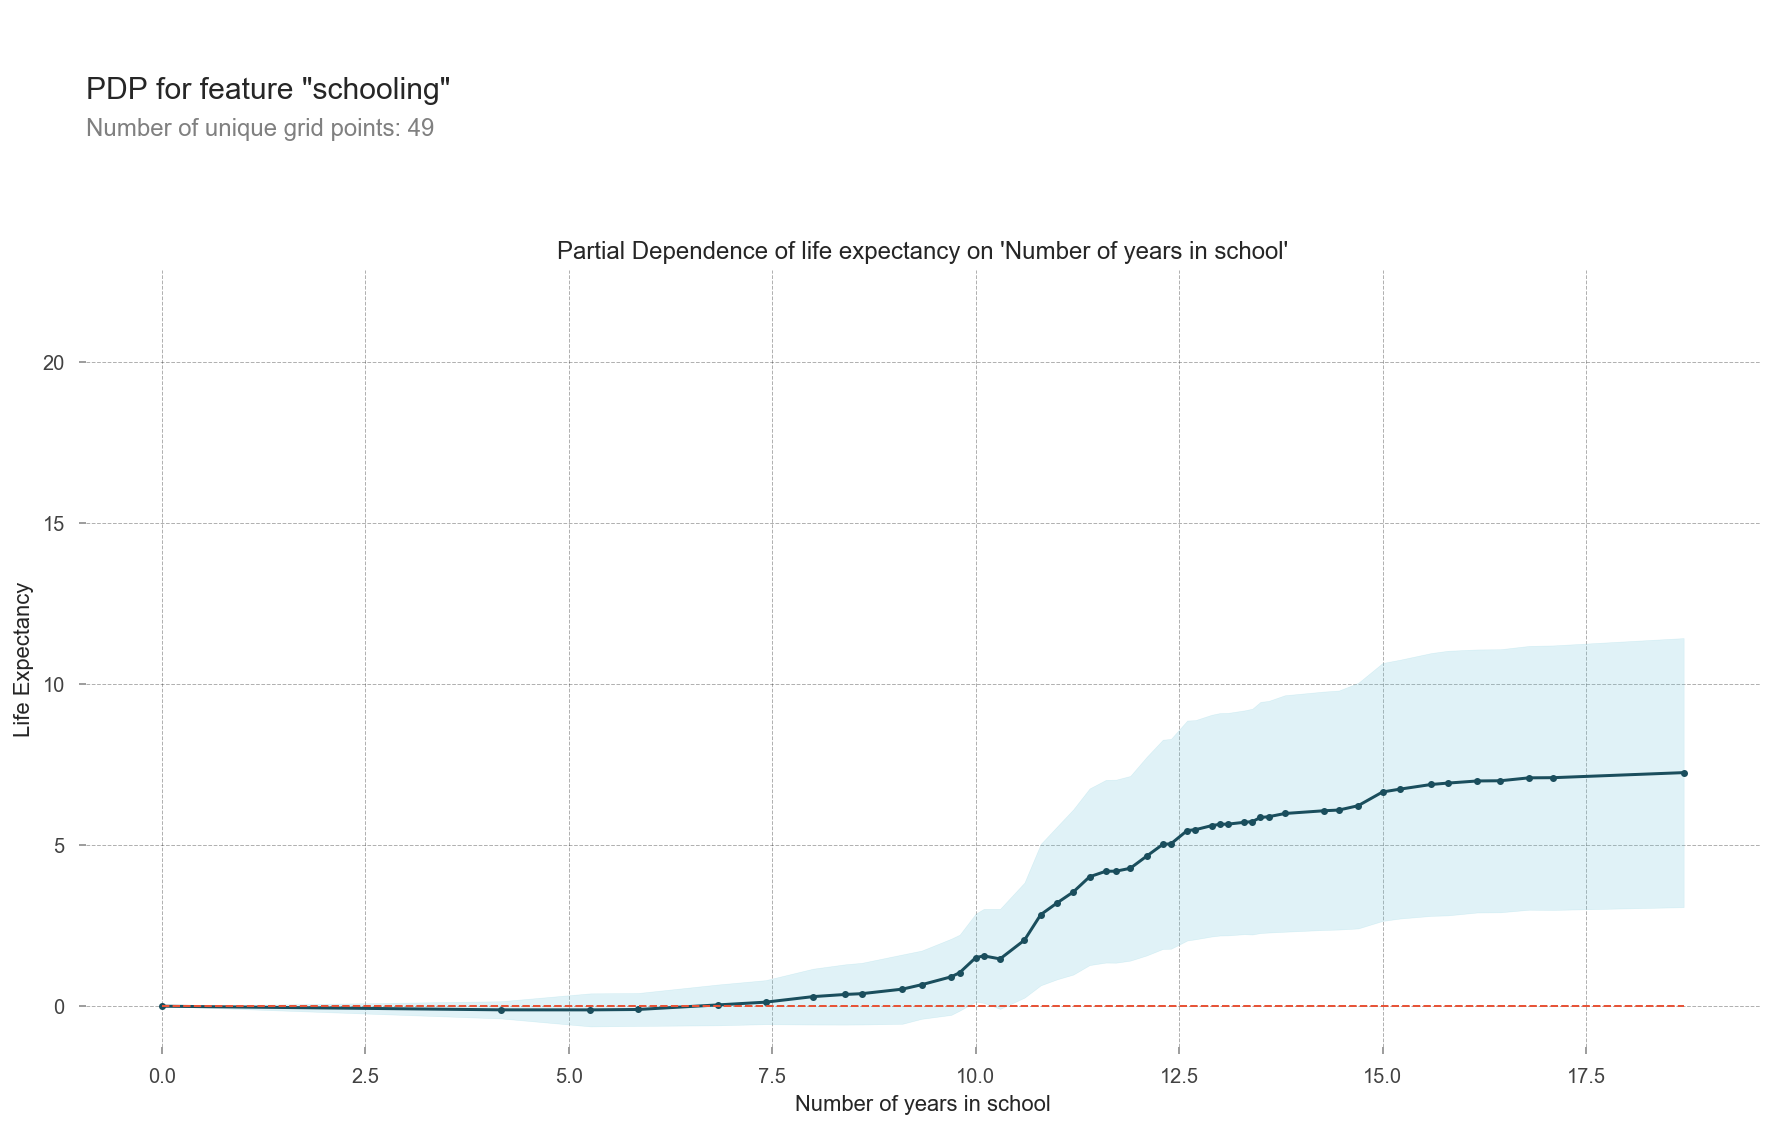

In [23]:
# pdp plot for schooling feature
pdp('schooling', 
    title="Partial Dependence of life expectancy on 'Number of years in school'",
    ylabel='Life Expectancy',
    xlabel = 'Number of years in school',
    xlim=(None))

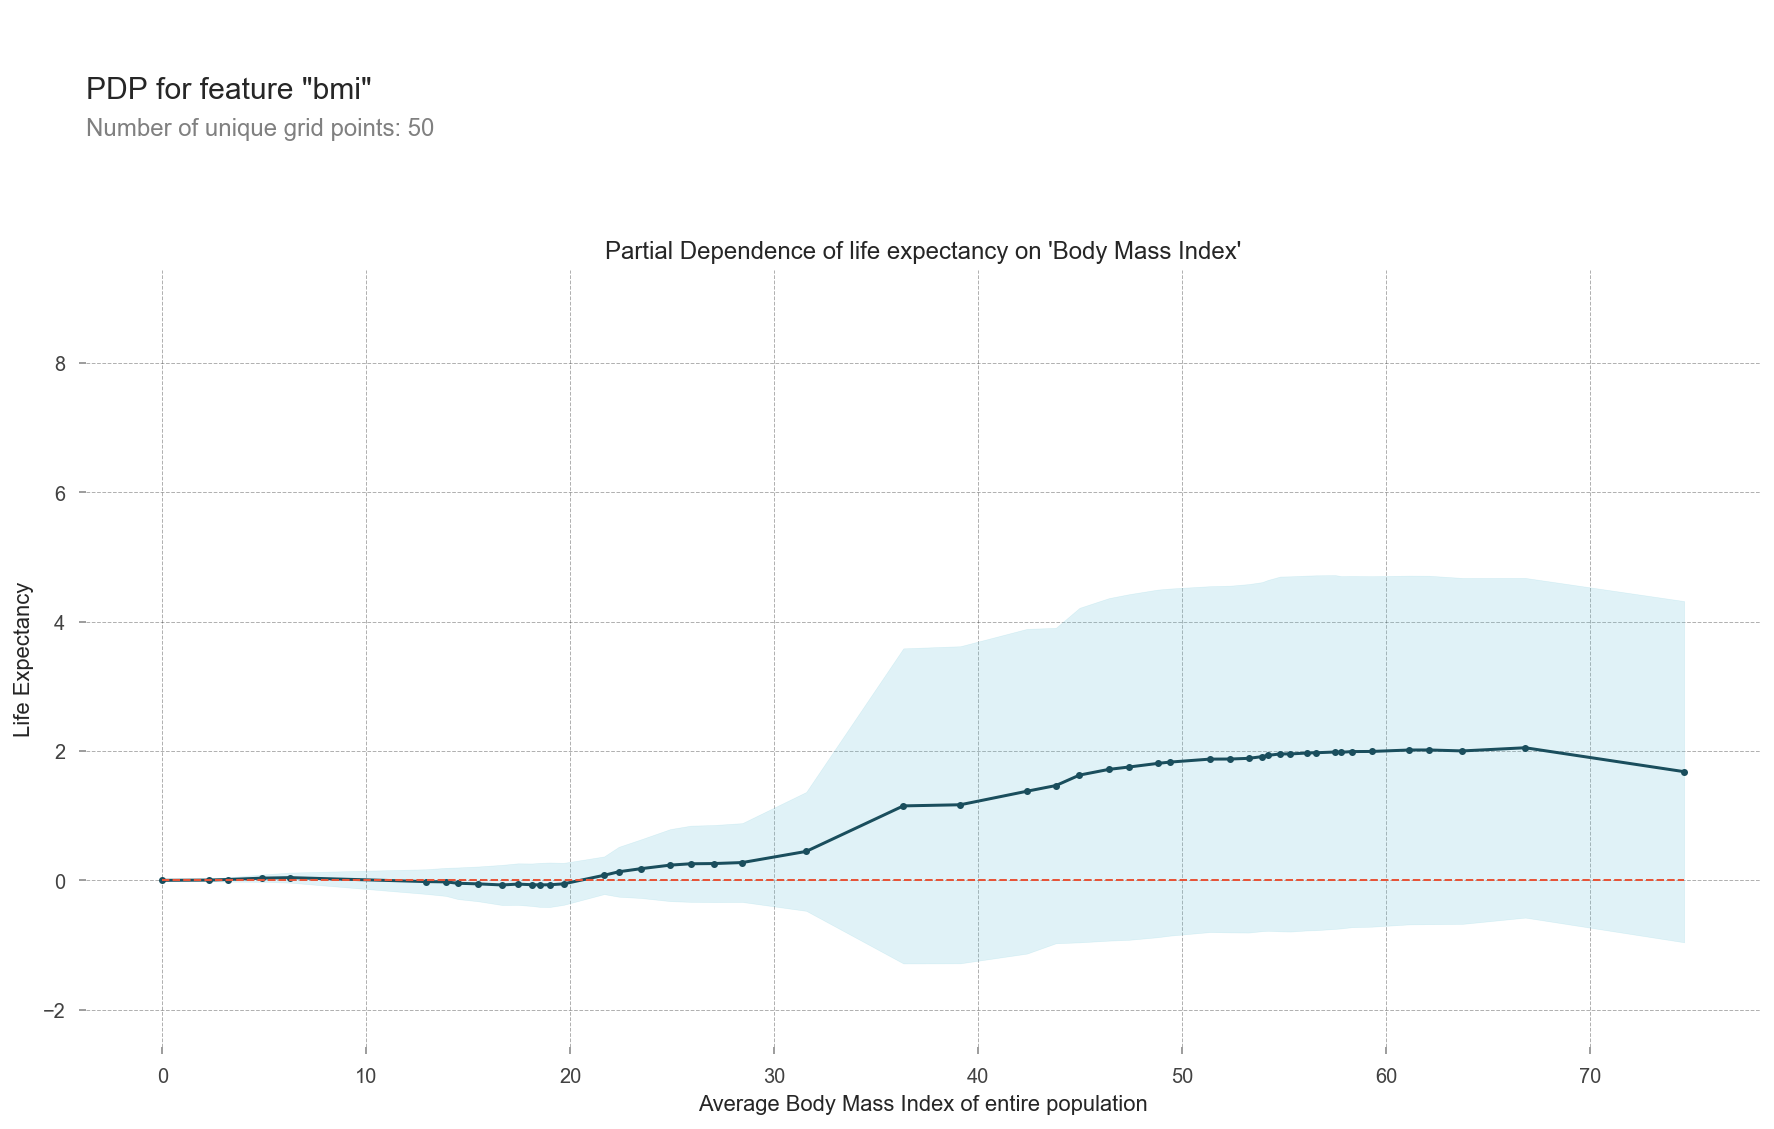

In [24]:
# pdp plot for schooling feature
pdp('bmi', 
    title="Partial Dependence of life expectancy on 'Body Mass Index'",
    ylabel='Life Expectancy',
    xlabel = 'Average Body Mass Index of entire population',
    xlim=(None))

In [25]:
#2d PDP Plot function

def pdp_2d(feature1, feature2, x_val, model, title=''):

  #Defining the parameters for the pdp interaction

  features=[feature1, feature2]

  interaction = pdp_interact(
    model=model,
    dataset=x_val,
    model_features = x_val.columns,
    features=features)
  
  # putting the pdp in a table format and plotting it

  # 2 options. 

  # option 1: This will just plot the pdp interaction

  #pdp_interact_plot(interaction, 
                    #plot_type='grid', feature_names=features)

  # Option 2: Taking the pdp interaction and plotting it using
  # a seaborn heatmap. 

  pdp = interaction.pdp.pivot_table(
    values='preds',
    columns=features[0],
    index=features[1])[::-1]

  plt.figure(figsize=(10,8))
  sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis', xticklabels=pdp.columns.values.round(2),
                 yticklabels=pdp.index.values.round(2))
  plt.title(title);

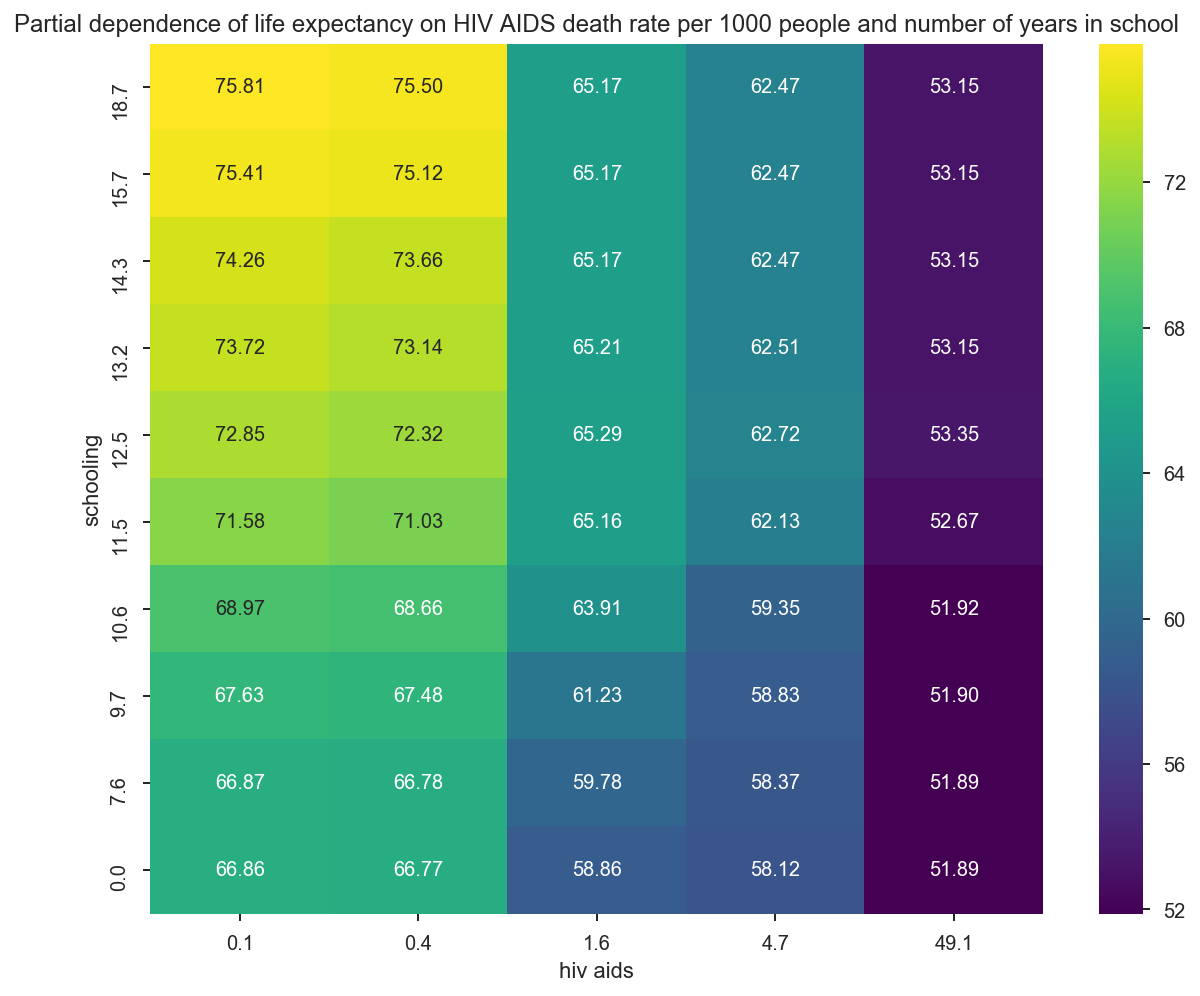

In [26]:
# 2d pdp plot of HIV Aids and Schooling

pdp_2d('hiv aids', 'schooling', x_val, forest,
       title='Partial dependence of life expectancy on HIV AIDS death rate per 1000 people and number of years in school')


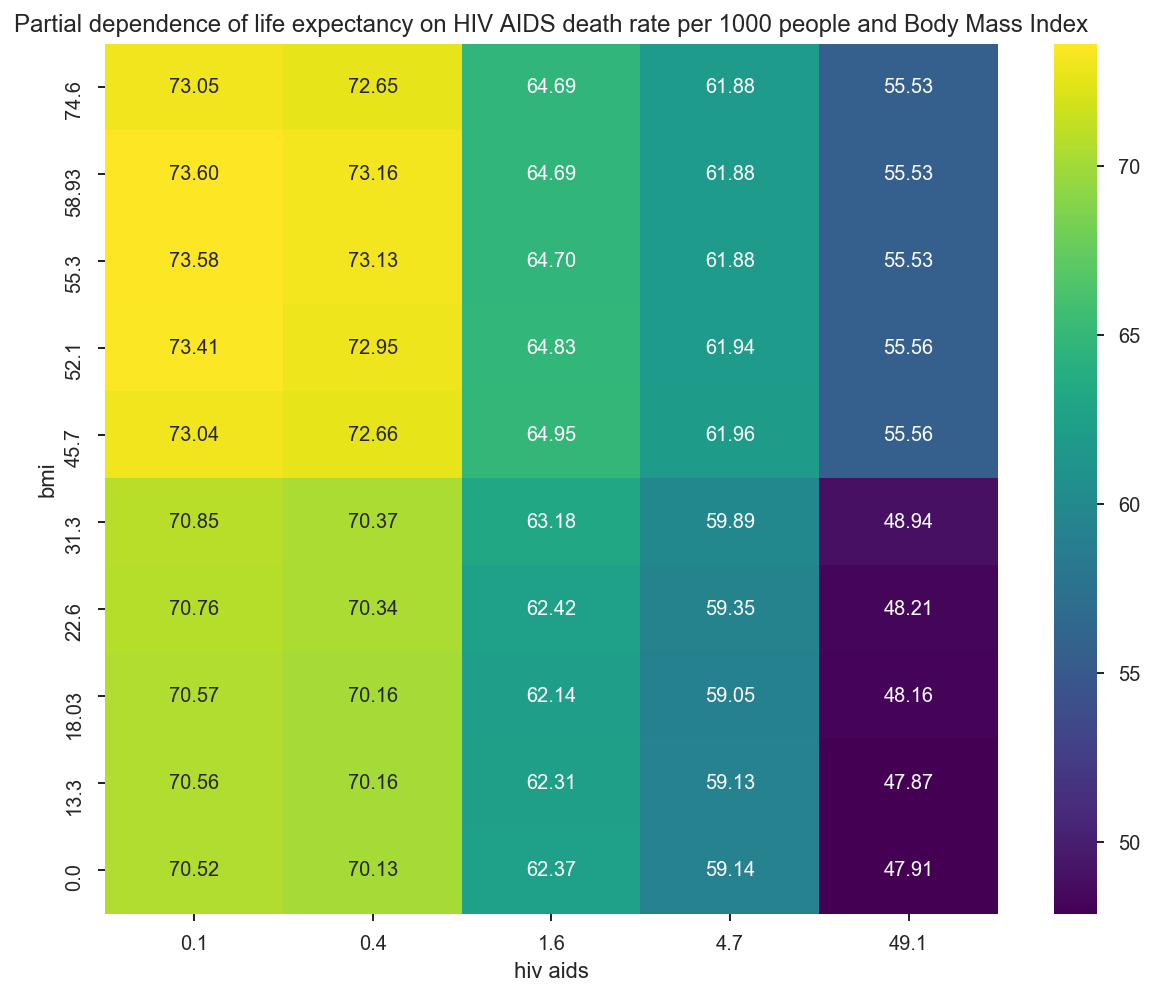

In [27]:
pdp_2d('hiv aids', 'bmi', x_val, forest,
       title='Partial dependence of life expectancy on HIV AIDS death rate per 1000 people and Body Mass Index')

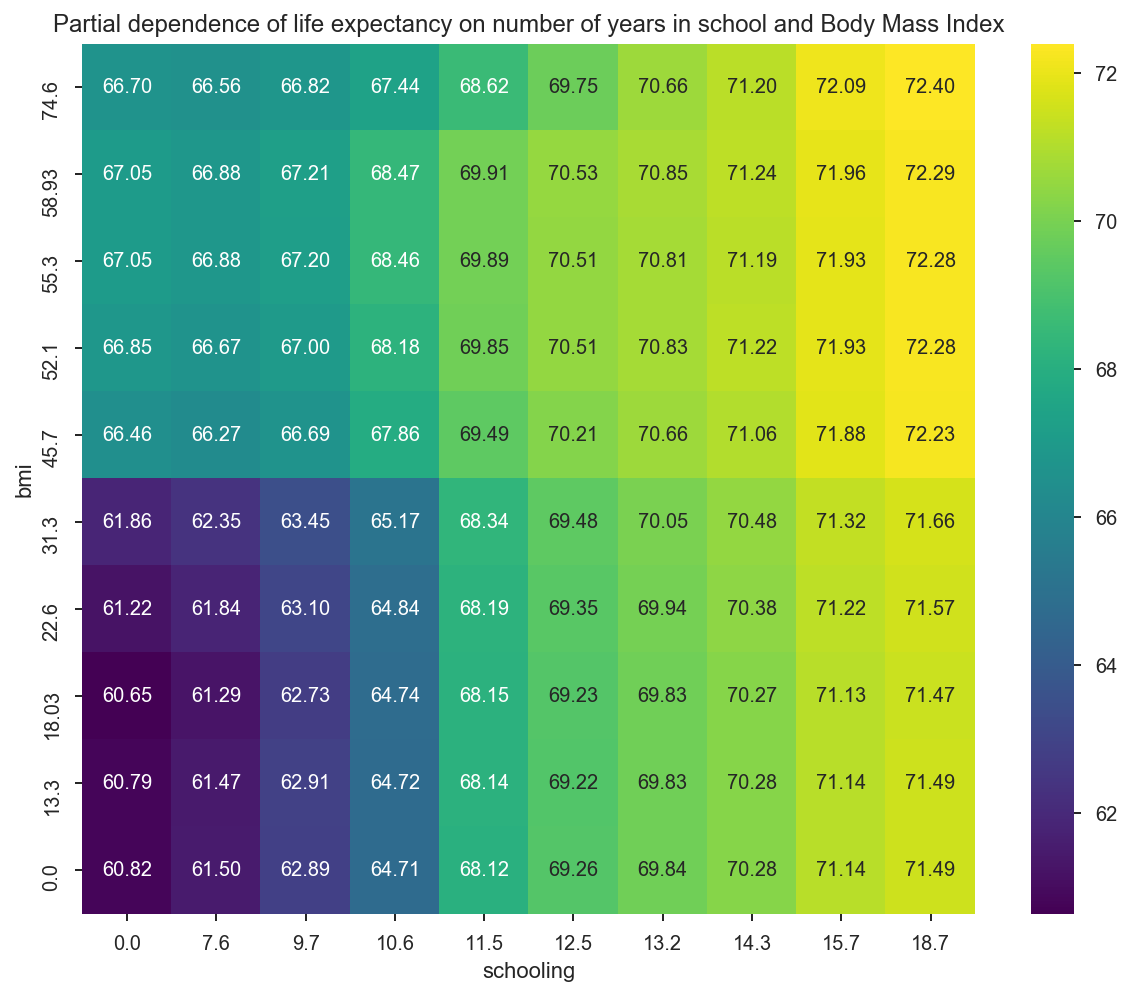

In [28]:
pdp_2d('schooling', 'bmi', x_val, forest,
       title='Partial dependence of life expectancy on number of years in school and Body Mass Index')

In [29]:
%%capture
!pip install chart_studio
import chart_studio

In [30]:
username = 'Ch00m' # your username
api_key = 'o25vnJpZRPmmD2aPfdjK' # your api key - go to profile > settings > regenerate key

chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

import chart_studio.plotly as py

import chart_studio.tools as tls

In [31]:
# 3d partial independence plots function

def pdp_3d(feature1, feature2, x_val, model, target, title='', embed_title=''):

  #Defining the parameters for the pdp interaction

  features=[feature1, feature2]

  interaction = pdp_interact(
    model=model,
    dataset=x_val,
    model_features = x_val.columns,
    features=features)
  
  # putting the pdp in a table format and plotting it

  pdp = interaction.pdp.pivot_table(
    values='preds',
    columns=features[0],
    index=features[1])[::-1]

  # defining the graph area for the 3d plot

  surface = go.Surface(
      x=pdp.columns,
      y=pdp.index,
      z=pdp.values
  )

  # defining the layout of the 3d graph. 
  layout = go.Layout(
      scene=dict(
          xaxis=dict(title=features[0]), 
          yaxis=dict(title=features[1]), 
          zaxis=dict(title=target),),
          title=(title))

  #Plotting the 3d graph

  fig = go.Figure(surface, layout)

  py.plot(fig, filename = embed_title, auto_open=True)
  
  fig.show()


In [32]:
pdp_3d('hiv aids', 'schooling', x_val, forest, 'life expectancy',
       title='Partial dependence of life expectancy on HIV AIDS death rate per 1000 people and number of years in school',
       embed_title = 'Hiv aids and schooling 3d plot')

In [33]:
pdp_3d('hiv aids', 'bmi', x_val, forest, 'life expectancy', 
       title='Partial dependence of life expectancy on HIV AIDS death rate per 1000 people and Body Mass Index',
       embed_title = 'Hiv aids and BMI 3d plot')

In [34]:
pdp_3d('schooling', 'bmi', x_val, forest, 'life expectancy', 
       title='Partial dependence of life expectancy on number of years in school and Body Mass Index',
       embed_title = 'Schooling and BMI 3d plot')

In [35]:
# function to do shapley plots. 

def shapley(x_train, y_train, x_val, row_number=0):

  # encoding the x features from training and validation dataset. 

  encoding = ce.OrdinalEncoder()

  x_train_encoded = encoding.fit_transform(x_train)
  x_val_encoded = encoding.transform(x_val)

  model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
  model.fit(x_train_encoded, y_train)

  # defining what row to examine in the shapley plot
  row = x_val_encoded.iloc[[row_number]]
  
  # predicting
  pred = model.predict(row)

  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(row)

  feature_names = row.columns
  feature_values = row.values[0]
  shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
  
  # printing the result

  result = f'{pred[0]:.1f}yrs is the predicted life expectancy. \n\n'
  result += f'Starting from baseline of {explainer.expected_value:.1f}yrs \n\n'
  result += shaps.to_string()
  print(result)

  shap.initjs()

  return shap.force_plot(
      base_value = explainer.expected_value,
      shap_values = shap_values,
      features=row)



In [36]:
shapley(x_train, y_train, x_val)

73.4yrs is the predicted life expectancy. 

Starting from baseline of 68.7yrs 

(status, 2.0)                 -0.245654
(alcohol, 3.63)                0.045245
(hepatitis b, 41.0)            0.007558
(measles, 0.0)                -0.095646
(bmi, 69.7)                    1.211272
(polio, 55.0)                 -0.173522
(total expenditure, 4.47)     -0.288335
(diphtheria, 49.0)            -0.404838
(hiv aids, 0.1)                3.552580
(gdp, 2571.262348)             0.038993
(population, 179929.0)         0.072461
(thinness  1 19 years, 0.2)    0.025485
(thinness 5 9 years, 0.2)      1.015295
(schooling, 12.6)             -0.012605


In [37]:
shapley(x_train, y_train, x_val, 13)

56.2yrs is the predicted life expectancy. 

Starting from baseline of 68.7yrs 

(status, 2.0)                 -0.027435
(alcohol, 1.34)                0.125863
(hepatitis b, 0.0)            -0.071908
(measles, 183.0)               0.146296
(bmi, 28.2)                   -0.263946
(polio, 46.0)                 -0.460445
(total expenditure, 5.75)      0.177429
(diphtheria, 46.0)            -0.286975
(hiv aids, 4.1)               -8.052009
(gdp, 768.176767)              0.313742
(population, 717584.0)         0.093328
(thinness  1 19 years, 6.4)   -0.117152
(thinness 5 9 years, 6.1)     -0.243612
(schooling, 2.9)              -3.847885


In [38]:
shapley(x_train, y_train, x_val, 1)

81.7yrs is the predicted life expectancy. 

Starting from baseline of 68.7yrs 

(status, 1.0)                  0.448235
(alcohol, 7.81)                0.169585
(hepatitis b, 0.0)            -0.042648
(measles, 0.0)                -0.149678
(bmi, 59.7)                    1.060922
(polio, 89.0)                 -0.029607
(total expenditure, 8.68)      0.159606
(diphtheria, 89.0)             0.057545
(hiv aids, 0.1)                4.689273
(gdp, 44333.8518)              0.776677
(population, 32716.0)          0.248235
(thinness  1 19 years, 1.0)    0.542070
(thinness 5 9 years, 0.9)      1.054989
(schooling, 18.7)              4.075082


In [39]:
shapley(x_train, y_train, x_val, 37)

54.4yrs is the predicted life expectancy. 

Starting from baseline of 68.7yrs 

(status, 2.0)                  -0.027883
(alcohol, 1.14)                 0.105570
(hepatitis b, 0.0)             -0.217622
(measles, 38.0)                 0.147011
(bmi, 18.9)                    -1.288152
(polio, 8.0)                   -0.479956
(total expenditure, 5.17)       0.102514
(diphtheria, 82.0)              0.176088
(hiv aids, 5.0)               -10.159168
(gdp, 372.1721837)             -0.270399
(population, 5683268.0)        -0.096877
(thinness  1 19 years, 8.4)    -0.172276
(thinness 5 9 years, 8.3)      -0.332877
(schooling, 10.1)              -1.747685


In [40]:
import plotly.express as px

hiv = px.scatter(train, x='hiv aids', y='life expectancy', 
           title='Relationship between hiv aids and life expectancy')
py.plot(hiv, filename = 'hiv aids and life expectancy', auto_open=True)
hiv

In [41]:
school = px.scatter(train, x='schooling', y='life expectancy', 
           title='Relationship between schooling and life expectancy')

py.plot(school, filename = 'schooling and life expectancy', auto_open=True)

school

In [42]:
bmi = px.scatter(train, x='bmi', y='life expectancy', 
           title='Relationship between bmi and life expectancy')

py.plot(bmi, filename = 'BMI and life expectancy', auto_open=True)

bmi

In [43]:
hiv_schooling = px.scatter_3d(test, x='hiv aids', y='life expectancy', z='schooling',
           title='Relationship between hiv aids, schooling, and life expectancy')

py.plot(hiv_schooling, filename = 'hiv aids, schooling, and life expectancy', auto_open=True)

hiv_schooling

In [44]:
hiv_bmi = px.scatter_3d(test, x='hiv aids', y='life expectancy', z='bmi',
           title='Relationship between HIV AIDS, BMI, and life expectancy')

py.plot(hiv_bmi, filename = 'hiv aids, bmi, and life expectancy', auto_open=True)

hiv_bmi

In [45]:
school_bmi = px.scatter_3d(test, x='schooling', y='life expectancy', z='bmi',
           title='Relationship between BMI, schooling, and life expectancy')

py.plot(school_bmi, filename = 'school, bmi, and life expectancy', auto_open=True)  

school_bmi